In [1]:
import numpy as np
import torch
#import gradio as gr
from huggingface_hub import from_pretrained_keras
import requests
from PIL import Image
import matplotlib.cm as cm
# import matplotlib.pyplot as plt
import os
import PIL

from torchvision import datasets, transforms

from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import models_vit
import utils
import torch.nn.functional as F
import pathlib

In [3]:
classes = ['Alicante', 'Alveralhao', 'Arinto', 'Bastardo', 'Boal',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Carignon Noir', 'Cercial',
       'Chardonnay', 'Codega', 'Codega do Larinho', 'Cornifesto',
       'Donzelinho Branco', 'Donzelinho Tinto', 'Esgana Cao',
       'Fernao Pires', 'Folgasao', 'Gamay', 'Gouveio', 'Malvasia Corada',
       'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Merlot',
       'Moscatel Galego', 'Moscatel Galego Roxo', 'Mourisco Tinto',
       'Pinot Blanc', 'Rabigato', 'Rufete', 'Samarrinho',
       'Sauvignon Blanc', 'Sousao', 'Tinta Amarela', 'Tinta Barroca',
       'Tinta Femea', 'Tinta Francisca', 'Tinta Roriz', 'Tinto Cao',
       'Touriga Francesa', 'Touriga Nacional', 'Viosinho']

In [10]:
target_size_dimension = 224
n_classes = len(classes)
model = 'vit_base_patch16'
#weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_only_imagenet/ft/base/checkpoint.pth'
#weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth'
#weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/bigger_dataset2/ft/base/2500/checkpoint-best.pth'
#weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/others/output_imagenet_v4/ft/base/2000/checkpoint-best.pth'

#merged
#weights = '/home/gabriel/Projects/mae/output_MergedDatasets/ft/ourPuls/checkpoint-best.pth'
#weights = '/home/gabriel/Projects/mae/output_MergedDatasets/ft/imagenet/checkpoint-best.pth'
weights = '/home/gabriel/Projects/mae/output_MergedDatasets/ft/ours/checkpoint-best.pth'
weights = '/home/gabriel/Projects/mae/output_MergedDatasets/ft/imagenetOurs/checkpoint-best.pth'

def get_last_selfattention(model, x):
    x = model.patch_embed(x)
    x = model._pos_embed(x)
    x = model.patch_drop(x)
    x = model.norm_pre(x)
    for i, blk in enumerate(model.blocks):
        if i < len(model.blocks) - 1:
            x = blk(x)
        else:
            x = blk.norm1(x)
            B, N, C = x.shape
            qkv = blk.attn.qkv(x).reshape(B, N, 3, blk.attn.num_heads, blk.attn.head_dim).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)
            q, k = blk.attn.q_norm(q), blk.attn.k_norm(k)

            if blk.attn.fused_attn:
                x = F.scaled_dot_product_attention(
                    q, k, v,
                    dropout_p=blk.attn.attn_drop.p,
                )
            else:
                q = q * blk.attn.scale
                attn = q @ k.transpose(-2, -1)
                attn = attn.softmax(dim=-1)

            return attn

In [11]:
#compose transform
t = []
t.append(
    transforms.Resize((target_size_dimension, target_size_dimension), interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
)
#t.append(transforms.CenterCrop(target_size_dimension))

t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
t = transforms.Compose(t)

model = models_vit.__dict__[model](
    num_classes=n_classes,
    global_pool=True,
    drop_path_rate = 0.1
)

print(weights)
state = torch.load(weights, map_location='cpu')
print(state.keys())
msg = model.load_state_dict(state['model'], strict=False)
print(msg)
model.to('cpu')
#model.to('cuda')
model.eval()


/home/gabriel/Projects/mae/output_MergedDatasets/ft/imagenetOurs/checkpoint-best.pth
dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
<All keys matched successfully>


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1-11): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (a

In [14]:

#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/processed/compilado/'
#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2'
#dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/aga-test/'
#dataset = '/home/gabriel/Downloads/castas-huge2-split/test/'
dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/castas-v7-2024/test/'

#ds = datasets.ImageFolder(dataset, transform=t)
ds = datasets.ImageFolder(dataset, transform=t, allow_empty=True)
sampler = torch.utils.data.SequentialSampler(ds)
dl = torch.utils.data.DataLoader(ds, sampler=sampler, batch_size=48, num_workers=1, pin_memory=True)

              precision    recall  f1-score   support

          AC     0.9600    1.0000    0.9796        24
          AV     0.8864    0.9512    0.9176        41
          AT     0.7381    0.7949    0.7654        39
          BT     0.9048    0.9048    0.9048        21
          BA     0.8387    0.7647    0.8000        34
          CF     0.7727    0.8095    0.7907        21
          CS     0.8500    0.8095    0.8293        21
          CN     0.9231    0.6316    0.7500        19
          CC     0.7222    0.7027    0.7123        37
          CD     0.7778    0.8235    0.8000        17
          CG     0.6923    0.7941    0.7397        34
          CR     0.8846    0.9583    0.9200        24
          CT     1.0000    0.8667    0.9286        15
          DB     0.7083    0.4474    0.5484        38
          DT     1.0000    0.8571    0.9231        14
          EC     0.7083    0.5152    0.5965        33
          FP     0.7692    0.8333    0.8000        24
          FG     0.7838    

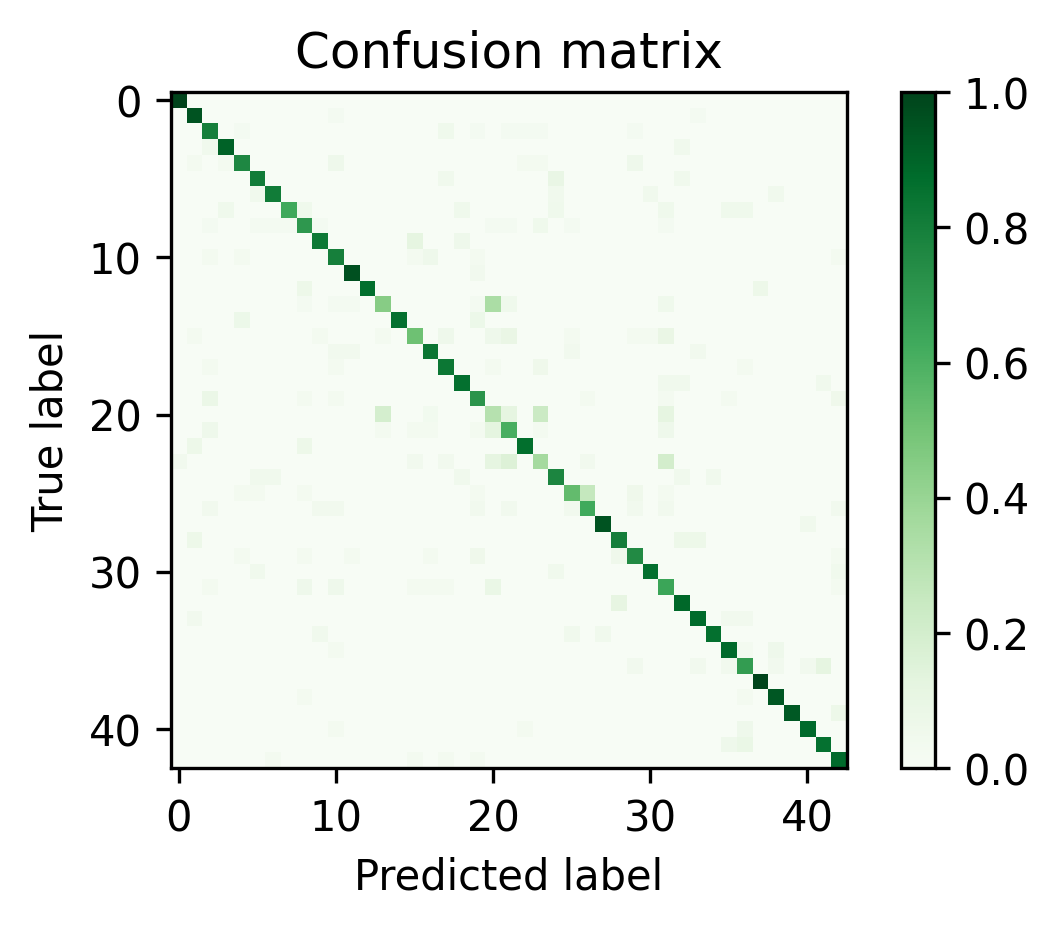

In [15]:
classes_alias = {'tinto cao': 'TC', 'tinta francisca': 'TF', 'alicante': 'AC', 'alveralhao': 'AV', 'arinto': 'AT', 'bastardo': 'BT', 'boal': 'BA', 'cabernet franc': 'CF', 'cabernet sauvignon': 'CS', 'carignon noir': 'CN', 'cercial': 'CC', 'chardonnay': 'CD', 'codega': 'CG', 'codega do larinho': 'CR', 'cornifesto': 'CT', 'donzelinho': 'DZ', 'donzelinho branco': 'DB', 'donzelinho tinto': 'DT', 'esgana cao': 'EC', 'fernao pires': 'FP', 'folgasao': 'FG', 'gamay': 'GM', 'gouveio': 'GV', 'malvasia corada': 'MC', 'malvasia fina': 'MF', 'malvasia preta': 'MP', 'malvasia rei': 'MR', 'merlot': 'ML', 'moscatel galego': 'MG', 'moscatel galego roxo': 'MX', 'mourisco tinto': 'MT', 'pinot blanc': 'PB', 'rabigato': 'RB', 'rufete': 'RF', 'samarrinho': 'SM', 'sauvignon blanc': 'SB', 'sousao': 'SS', 'tinta amarela': 'TA', 'tinta barroca': 'TB', 'tinta femea': 'TM', 'tinta roriz': 'TR', 'touriga francesa': 'TS', 'touriga nacional': 'TN', 'viosinho': 'VO'}
report, result = utils.confusion_matrix(dl, model, class_labels=[classes_alias[c.lower()] for c in classes],mode='pytorch', sns=False, normalize=True, return_images_paths=True, only_heatmap=True, cmap='Greens')

In [36]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/gabriel/Projects/mae/utils.py'>

In [8]:
import json

json.dumps(classes_alias)

'{"tinto cao": "TC", "tinta francisca": "TF", "alicante": "AC", "alveralhao": "AV", "arinto": "AT", "bastardo": "BT", "boal": "BA", "cabernet franc": "CF", "cabernet sauvignon": "CS", "carignon noir": "CN", "cercial": "CC", "chardonnay": "CD", "codega": "CG", "codega do larinho": "CR", "cornifesto": "CT", "donzelinho": "DZ", "donzelinho branco": "DB", "donzelinho tinto": "DT", "esgana cao": "EC", "fernao pires": "FP", "folgasao": "FG", "gamay": "GM", "gouveio": "GV", "malvasia corada": "MC", "malvasia fina": "MF", "malvasia preta": "MP", "malvasia rei": "MR", "merlot": "ML", "moscatel galego": "MG", "moscatel galego roxo": "MX", "mourisco tinto": "MT", "pinot blanc": "PB", "rabigato": "RB", "rufete": "RF", "samarrinho": "SM", "sauvignon blanc": "SB", "sousao": "SS", "tinta amarela": "TA", "tinta barroca": "TB", "tinta femea": "TM", "tinta roriz": "TR", "touriga francesa": "TS", "touriga nacional": "TN", "viosinho": "VO"}'

In [9]:
images = []

import random
import pandas as pd
import shutil
for tc, well_classifier, path in result:
    print(path)
    if well_classifier:
        split = path[0].split(os.sep)
        dic = {}
        dic['class'] = split[-2]
        dic['path'] = path
        try:
            dic['cam'] = split[-1].split(',')[1]
        except:
            dic['cam'] = '0'

        images.append(dic)
        print(f'{tc} -> {well_classifier} -> {path}')

df = pd.DataFrame.from_records(images)


classes = np.unique(df['class'])
save_images = '/home/gabriel/Downloads/selected_castasv6_xai/'
os.makedirs(save_images, exist_ok=True)
images_final = []
for c in classes:
    df_filtred = df[df['class'] == c]
    cam = random.choice(df_filtred['cam'].values)
    df_filtred = df_filtred[df_filtred['cam'] == cam]
    chosen = random.choice(df_filtred['path'].values)
    shutil.copy(chosen, os.path.join(save_images, f'{chosen.split(os.sep)[-1]}'))




    

('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105428.jpg', 0)
0 -> True -> ('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105428.jpg', 0)
('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105432.jpg', 0)
0 -> True -> ('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105432.jpg', 0)
('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105436.jpg', 0)
('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105443.jpg', 0)
0 -> True -> ('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105443.jpg', 0)
('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105446.jpg', 0)
('/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/weekly/week2/Alicante/Galaxy_S23,20240717_105452.jpg', 0

AttributeError: 'tuple' object has no attribute 'split'